# Controlling locomotion with CPGs

**Authors:** Sibo Wang-Chen, Femke Hurtak

**Note:** The code presented in this notebook has been simplified and restructured for display in a notebook format. A more complete and better structured implementation can be found in the [examples folder of the FlyGym repository on GitHub](https://github.com/NeLy-EPFL/flygym/tree/main/flygym/examples/).

**Summary:** In this tutorial, we will introduce the concept of Central Pattern Generators (CPGs) and build a CPG-based model to control walking of the simulated fly.

Central Pattern Generators (CPGs) are neural circuits that generate rhythmic output without receiving rhythmic input (see review of CPGs in insects by [Mantziaris et al, 2020](https://doi.org/10.1002/dneu.22738)). CPGs have been identified in various species as playing a crucial role in locomotion. Their principles have also been adopted in the realm of robotic motor control (see review by [Ijspeert, 2008](https://doi.org/10.1016/j.neunet.2008.03.014)). It is hypothesized that CPGs play a more important role in animals whose locomotion is fast and therefore cannot process decentralized limb sensory signals in time to adjust their movements (i.e., like cockroaches running at ~1 m/s!).

In this tutorial, we will start by implementing an oscillator network. Then, we will use this network to control the stepping of the legs by mapping the phases of the oscillators to the phases of preprogrammed leg stepping kinematics. Next, we will plug this oscillator-based controller into NeuroMechFly to drive locomotion in the physics simulation. Finally, we will add leg adhesion to the locomotor simulation.

## The CPG network

Basic CPGs can be implemented as feedforward networks of oscillators—in other words, the network behaves without taking into account sensory feedback. Similar to the formulation from [Ijspeert et al (2007)](https://doi.org/10.1126/science.1138353), the oscillator network can be described by the following ordinary differential equations (ODEs):
$$ \dot\theta_i = 2\pi\nu_i + \sum_{j} r_j w_{ij} \sin(\theta_j - \theta_i - \phi_{ij}) $$
$$ \dot r_i = \alpha_i (R_i - r_i) $$
where $\theta_i$ and $r_i$ are the current phase and magnitude of the i-th oscillator. $R_i$ is the maximum amplitude of the i-th oscillator, and $\alpha_i$ is a constant determining the rate of convergence to synchrony. $w_{ij}$ is the coupling weight between the i-th and the j-th oscillator, and $\phi_{ij}$ is the phase bias between them. Intuitively, the first term of the first equation maintains an intrinsic frequency for each oscillator; the second term of the first equation keeps the oscillators synchronized (i.e., maintains the phase differences between the oscillators), and the second equation maintains the amplitudes of the oscillators.

To start, let's write a function that computes $\dot\theta$ and $\dot r$. For explicitness, we will implement the CPG network using only Python and NumPy (no `scipy.integrate`).

In [6]:
import numpy as np


def calculate_ddt(theta, r, w, phi, nu, R, alpha):
    """Given the current state variables theta, r and network parameters
    w, phi, nu, R, alpha, calculate the time derivatives of theta and r."""
    intrinsic_term = 2 * np.pi * nu
    phase_diff = theta[np.newaxis, :] - theta[:, np.newaxis]
    coupling_term = (r * w * np.sin(phase_diff - phi)).sum(axis=1)
    dtheta_dt = intrinsic_term + coupling_term
    dr_dt = alpha * (R - r)
    return dtheta_dt, dr_dt

Next, let's implement the CPG as a class. We will use [Euler's method](https://en.wikipedia.org/wiki/Euler_method) to integrate the ODE, but you can use any higher-order methods or libraries.

In [7]:
class CPGNetwork:
    def __init__(
        self,
        timestep,
        intrinsic_freqs,
        intrinsic_amps,
        coupling_weights,
        phase_biases,
        convergence_coefs,
        init_phases=None,
        init_magnitudes=None,
        seed=0,
    ) -> None:
        """Initialize a CPG network consisting of N oscillators.

        Parameters
        ----------
        timestep : float
            The timestep of the simulation.
        intrinsic_freqs : np.ndarray
            The intrinsic frequencies of the oscillators, shape (N,).
        intrinsic_amps : np.ndarray
            The intrinsic amplitude of the oscillators, shape (N,).
        coupling_weights : np.ndarray
            The coupling weights between the oscillators, shape (N, N).
        phase_biases : np.ndarray
            The phase biases between the oscillators, shape (N, N).
        convergence_coefs : np.ndarray
            Coefficients describing the rate of convergence to oscillator
            intrinsic amplitudes, shape (N,).
        init_phases : np.ndarray, optional
            Initial phases of the oscillators, shape (N,). The phases are
            randomly initialized if not provided.
        init_magnitudes : np.ndarray, optional
            Initial magnitudes of the oscillators, shape (N,). The
            magnitudes are randomly initialized if not provided.
        seed : int, optional
            The random seed to use for initializing the phases and
            magnitudes.
        """
        self.timestep = timestep
        self.num_cpgs = intrinsic_freqs.size
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.coupling_weights = coupling_weights
        self.phase_biases = phase_biases
        self.convergence_coefs = convergence_coefs
        self.random_state = np.random.RandomState(seed)

        self.reset(init_phases, init_magnitudes)

        # Check if the parameters have the right shape
        assert intrinsic_freqs.shape == (self.num_cpgs,)
        assert coupling_weights.shape == (self.num_cpgs, self.num_cpgs)
        assert phase_biases.shape == (self.num_cpgs, self.num_cpgs)
        assert convergence_coefs.shape == (self.num_cpgs,)
        assert self.curr_phases.shape == (self.num_cpgs,)
        assert self.curr_magnitudes.shape == (self.num_cpgs,)

    def step(self):
        """Integrate the ODEs using Euler's method."""
        dtheta_dt, dr_dt = calculate_ddt(
            theta=self.curr_phases,
            r=self.curr_magnitudes,
            w=self.coupling_weights,
            phi=self.phase_biases,
            nu=self.intrinsic_freqs,
            R=self.intrinsic_amps,
            alpha=self.convergence_coefs,
        )
        self.curr_phases += dtheta_dt * self.timestep
        self.curr_magnitudes += dr_dt * self.timestep

    def reset(self, init_phases=None, init_magnitudes=None):
        """Reset the phases and magnitudes of the oscillators.
        High magnitudes and unfortunate phases might cause physics error
        """
        if init_phases is None:
            self.curr_phases = self.random_state.random(self.num_cpgs) * 2 * np.pi
        else:
            self.curr_phases = init_phases

        if init_magnitudes is None:
            self.curr_magnitudes = np.zeros(self.num_cpgs)
        else:
            self.curr_magnitudes = init_magnitudes

To demonstrate this network, let's simulate a network of three oscillators connected as follows:

<img src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/cpg_controller/simple_cpg.png" alt="simple_cpg" width="500"/>

For the sake of illustration, let's make them oscillate at an intrinsic frequency of 1 and intrinsic amplitudes of 1.0, 1.1, 1.2. They are coupled with a weight of 1 and phase differences of 120 degrees. We will initialize the phases and magnitudes randomly.

In [8]:
intrinsic_freqs = np.ones(3)
intrinsic_amps = np.array([1.0, 1.1, 1.2])
coupling_weights = np.array(
    [
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0],
    ]
)
phase_biases = np.deg2rad(
    np.array(
        [
            [0, 120, 0],
            [-120, 0, 120],
            [0, -120, 0],
        ]
    )
)
convergence_coefs = np.ones(3)

network = CPGNetwork(
    timestep=1e-3,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

num_steps = int(10 / network.timestep)
phase_hist = np.empty((num_steps, 3))
magnitude_hist = np.empty((num_steps, 3))

# Simulate the network
for i in range(num_steps):
    network.step()
    phase_hist[i, :] = network.curr_phases
    magnitude_hist[i, :] = network.curr_magnitudes

We can visualize the phases (wrapped to $[0, 2\pi]$) and the magnitudes of the oscillators over time. We observe that, after a brief period of synchronization, the oscillators converge to a state where they oscillate 1/3 of a cycle apart at their intrinsic frequencies and amplitudes.

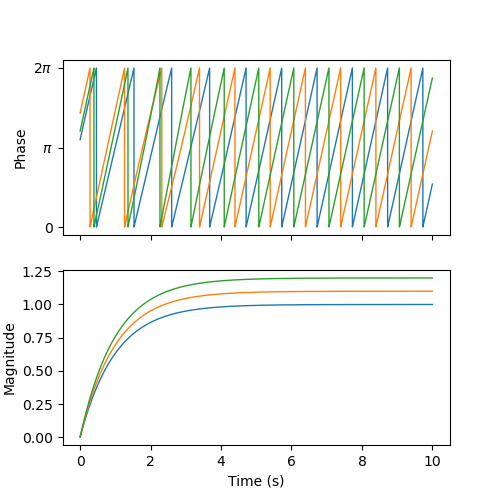

In [9]:
from pathlib import Path
import matplotlib.pyplot as plt

output_dir = Path("./outputs")
output_dir.mkdir(exist_ok=True, parents=True)

fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
t = np.arange(num_steps) * network.timestep
axs[0].plot(t, phase_hist % (2 * np.pi), linewidth=1)
axs[0].set_yticks([0, np.pi, 2 * np.pi])
axs[0].set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
axs[0].set_ylabel("Phase")
axs[1].plot(t, magnitude_hist, linewidth=1)
axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Time (s)")
fig.savefig(output_dir / "simple_cpg_rollout.png")

We have now built a CPG network. In the next section, we address how the states of the CPGs can be used to drive locomotion.

## Controlling leg stepping with CPGs

The state variables $\theta$ and $r$ can be used to drive locomotion at various levels of abstraction. This is a design choice that the modeler should make depending on the scientific question being considered. For example, in [Lobato-Rios et al (2022)](https://doi.org/10.1038/s41592-022-01466-7), the CPG states are used to calculate motor neuron activity $M_i = r_i (1 + \sin(\theta_i))$, which is in turn used to drive a muscle model. By contrast, [Ijspeert et al (2007)](https://doi.org/10.1126/science.1138353) uses a more abstract control strategy — the CPG states directly control the target joint *position* (i.e. angle) $x_i = r_i (1 + \cos(\theta_i))$. This target position is then provided to a [proportional-derivative (PD) controller](https://www.matthewpeterkelly.com/tutorials/pdControl/index.html) which actuates the joint.

Here, we will use an even higher-level control approach where each oscillator controls the stepping of an entire leg (as opposed to a joint). The phase of the CPG represents the phase of the step (i.e. how far into the step the leg is), while the magnitude of the CPG represents the magnitude of the step (i.e. how large the step is). We will use experimentally recorded data to execute the individual steps. In other words, we will extract the kinematics of a single step for each leg from experimental behavior recordings and modify its magnitude (modulated by $r$) and speed (modulated by $\theta$) so that the stepping of the six legs is coordinated by the CPG network.

We will set the coupling parameters for locomotion using a "tripod gait": at each point in time, the fore and hind legs on one side and the mid leg on the other side of the body are in stance, forming a stable tripod-shaped structure; the other three legs are in swing. This is illustrated in the figure below (left, figure adapted from [Emanuel et al, 2020](https://doi.org/10.3389/fphys.2020.00135)). The tripod gait can be implemented using a CPG network shown on the right. We observe that the legs that should *not* swing together are coupled with a phase difference of 180 degrees, ensuring that they are out of phase once the network is synchronized. We will use other parameters from the [NeuroMechFly v2 paper](https://www.biorxiv.org/content/10.1101/2023.09.18.556649).

<img src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/cpg_controller/tripod_cpg.png" alt="simple_cpg" width="600"/>

As before, we will set up the CPG network, run the simulation, and plot the time series of the state variables:

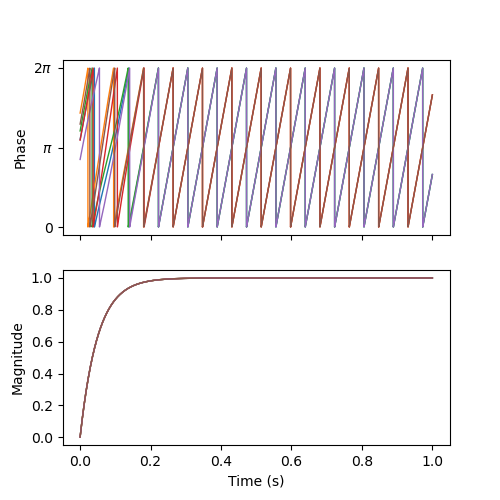

In [10]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
)

# Simulate the network
num_steps = int(1 / network.timestep)
phase_hist = np.empty((num_steps, 6))
magnitude_hist = np.empty((num_steps, 6))
for i in range(num_steps):
    network.step()
    phase_hist[i, :] = network.curr_phases
    magnitude_hist[i, :] = network.curr_magnitudes

# Visualize
fig, axs = plt.subplots(2, 1, figsize=(5, 5), sharex=True)
t = np.arange(num_steps) * network.timestep
axs[0].plot(t, phase_hist % (2 * np.pi), linewidth=1)
axs[0].set_yticks([0, np.pi, 2 * np.pi])
axs[0].set_yticklabels(["0", r"$\pi$", r"$2\pi$"])
axs[0].set_ylabel("Phase")
axs[1].plot(t, magnitude_hist, linewidth=1)
axs[1].set_ylabel("Magnitude")
axs[1].set_xlabel("Time (s)")
fig.savefig(output_dir / "tripod_cpg_rollout.png")

Now, let's load the behavior kinematics data:

In [11]:
import pickle
from flygym.util import get_data_path

single_steps_path = (
    get_data_path("flygym", "data") / "behavior/single_steps_untethered.pkl"
)
with open(single_steps_path, "rb") as f:
    single_steps_data = pickle.load(f)

This gives us a dictionary containing joint angle time series for each joint. We will check if they all have the same length. The steps should be periodic, so we will also check if the first and last angles in the time series are the same:

In [12]:
preprogrammed_steps_length = len(single_steps_data["joint_LFCoxa"])
preprogrammed_steps_timestep = single_steps_data["meta"]["timestep"]
print(
    f"Preprogrammed steps have a length of {preprogrammed_steps_length} steps "
    f"at dt={preprogrammed_steps_timestep}s."
)
for k, v in single_steps_data.items():
    if k.startswith("joint_"):
        assert len(v) == preprogrammed_steps_length
        assert v[0] == v[-1]

Preprogrammed steps have a length of 45 steps at dt=0.003s.


Now, for each leg $i$, let's build a function $\Psi_i$ such that given the current stepping phase $\theta_i$ of the leg, $\Psi_i(\theta_i)$ provides joint angles of all DoFs on leg $i$ based on the preprogrammed stepping kinematics. We will do this by interpolation and normalize $\theta$ to the range $[0, 2\pi)$:

In [13]:
from scipy.interpolate import CubicSpline

legs = [f"{side}{pos}" for side in "LR" for pos in "FMH"]
dofs_per_leg = [
    "Coxa",
    "Coxa_roll",
    "Coxa_yaw",
    "Femur",
    "Femur_roll",
    "Tibia",
    "Tarsus1",
]
phase_grid = np.linspace(0, 2 * np.pi, preprogrammed_steps_length)
psi_funcs = {}
for leg in legs:
    joint_angles = np.array(
        [single_steps_data[f"joint_{leg}{dof}"] for dof in dofs_per_leg]
    )
    psi_funcs[leg] = CubicSpline(
        x=phase_grid,
        y=joint_angles,
        axis=1,
        bc_type="periodic",
    )

We can then map the phase of the CPGs to the phase of the legs. Let's visualize three stepping cycles for each leg:

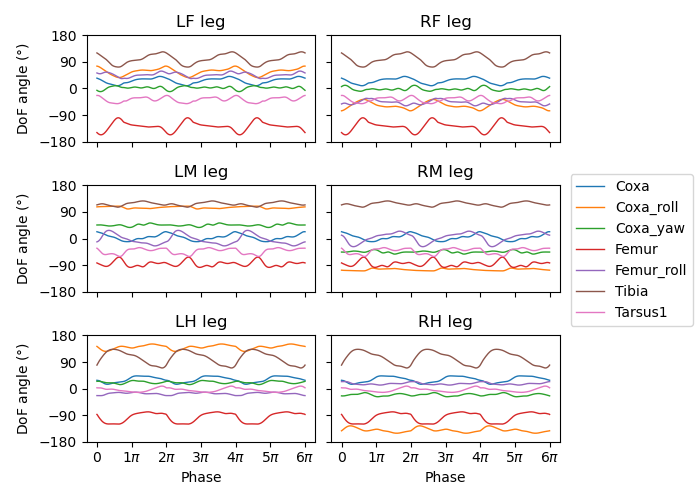

In [14]:
theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)

joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    joint_angles_by_leg[leg] = psi_func(theta_ts)

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "three_steps_phase_only.png")

We can also modulate the amplitude of the steps using the magnitude $r$ of the CPGs. To do this, we take the difference of the joint angles from the neutral positions and scale it by $r$. The final joint positions are therefore $\Psi_0 + r(\Psi - \Psi_0)$. We will use the beginnings of the preprogrammed steps (right before the start of the swing) as the neutral positions.

Let's repeat the previous exercise, but gradually ramp up the amplitude from 0 to 1:

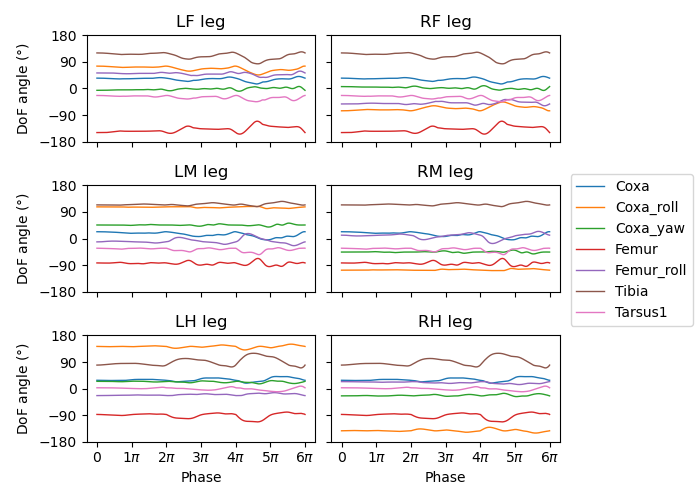

In [15]:
theta_ts = np.linspace(0, 3 * 2 * np.pi, 10000)
r_ts = np.linspace(0, 1, 10000)

##### THIS SECTION HAS CHANGED #####
joint_angles_by_leg = {}
for leg, psi_func in psi_funcs.items():
    neutral_pos = psi_func(0)[:, np.newaxis]
    joint_angles_by_leg[leg] = neutral_pos + r_ts * (psi_func(theta_ts) - neutral_pos)
####################################

fig, axs = plt.subplots(3, 2, figsize=(7, 5), sharex=True, sharey=True)
for i_side, side in enumerate("LR"):
    for i_pos, pos in enumerate("FMH"):
        leg = f"{side}{pos}"
        ax = axs[i_pos, i_side]
        psi_func = psi_funcs[leg]
        joint_angles = np.rad2deg(joint_angles_by_leg[leg])
        for i_dof, dof_name in enumerate(dofs_per_leg):
            legend = dof_name if i_pos == 0 and i_side == 0 else None
            ax.plot(theta_ts, joint_angles[i_dof, :], linewidth=1, label=legend)
        if i_pos == 2:
            ax.set_xlabel("Phase")
            ax.set_xticks(np.pi * np.arange(7))
            ax.set_xticklabels(["0" if x == 0 else rf"{x}$\pi$" for x in np.arange(7)])
        if i_side == 0:
            ax.set_ylabel(r"DoF angle ($\degree$)")
        ax.set_title(f"{leg} leg")
        ax.set_ylim(-180, 180)
        ax.set_yticks([-180, -90, 0, 90, 180])
fig.legend(loc=7)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
fig.savefig(output_dir / "three_steps_amp_modulated.png")

We have now built the individual elements of the controller:

- On the level of inter-leg coordination, the CPG network controls the phase $\theta$ of each leg of the magnitude $r$ of its steps.
- On the level of per-leg kinematics, we find the corresponding joint states at the phase $\theta$ based on experimentally recorded data, scaled by the amplitude $r$.

In the next section, we will piece these components together and plug them into the physics simulation.

## Plugging the controller into the simulation

We will now put everything together and control the simulated fly using the controller that we have designed. The following content assumes that you have read the tutorial ["Interacting with NeuroMechFly"](https://neuromechfly.org/tutorials/gym_basics_and_kinematic_replay.html).

We start by initializing the simulation:

In [16]:
from flygym import Fly, ZStabilizedCamera, SingleFlySimulation
from flygym.preprogrammed import all_leg_dofs

run_time = 1
fly = Fly(
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
)
cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
)
sim = SingleFlySimulation(fly=fly, cameras=[cam], timestep=1e-4)

We will also initialize a CPG network:

In [17]:
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 1000

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=1,
)

In [18]:
swing_start = np.empty(6)
swing_end = np.empty(6)
for i, leg in enumerate(legs):
    swing_start[i] = single_steps_data["swing_stance_time"]["swing"][leg]
    swing_end[i] = single_steps_data["swing_stance_time"]["stance"][leg]
swing_start /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_start *= 2 * np.pi
swing_end /= preprogrammed_steps_length * preprogrammed_steps_timestep
swing_end *= 2 * np.pi

# have the rest phase in between the swing and stance phase (as the data starts with swing initiation)
psi_rest_phases = np.ones_like(swing_start)
for i, leg in enumerate(legs):
    psi_rest_phases[i] = (swing_end[i] + 2 * np.pi) / 2

Let's run the simulation:

In [19]:
from tqdm import trange
from IPython.display import Video

obs, info = sim.reset()
for _ in trange(int(run_time / sim.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    action = {"joints": np.array([joints_angles[dof] for dof in fly.actuated_joints])}
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "cpg_controller.mp4", 0)
Video(output_dir / "cpg_controller.mp4")

100%|██████████| 10000/10000 [00:30<00:00, 332.50it/s]


## Leg adhesion

Insects, including flies, have evolved highly specialized adhesive structures to facilitate locomotion over complex 3D terrain. Substantial normal forces (10–100 times body weight) and frictional forces emerge from interactions between the adhesive pads and underlying substrates. These allow insects to navigate 3D terrain with ease. Because we cannot fully represent the physics underlying real, biological adhesion, we added a more abstract leg adhesion to our model by injecting an additional normal force to the pretarsus of each leg when it is in contact with a substrate. This adhesive force increases the normal force toward the object and the frictional force.

Despite the huge forces generated by adhesive pads, insects can still lift their legs, seemingly with out effort. The mechanisms for lifting off are not well understood in *Drosophila*. Therefore, we abstracted the mechanisms used by other insects for lifting by turning adhesion forces on during stance and off during swing phases. In the preprogrammed stepping data, we have also indicated the start (in seconds) of the swing and stance periods:

In [20]:
single_steps_data["swing_stance_time"]

{'swing': {'RF': np.float64(0.0),
  'RM': np.float64(0.0),
  'RH': np.float64(0.0),
  'LF': np.float64(0.0),
  'LM': np.float64(0.0),
  'LH': np.float64(0.0)},
 'stance': {'RF': np.float64(0.051000000000000004),
  'RM': np.float64(0.048),
  'RH': np.float64(0.042),
  'LF': np.float64(0.051000000000000004),
  'LM': np.float64(0.048),
  'LH': np.float64(0.042)}}

Let's write a function that, given the phases of the legs, return a boolean mask indicating whether adhesion should be on (during stance) or off (during swing):

In [21]:
def get_adhesion_onoff(theta):
    theta = theta % (2 * np.pi)
    return ~((theta > swing_start) & (theta < swing_end)).squeeze()

To illustrate this binary signal (low = off, during swing; high = on, during stance):

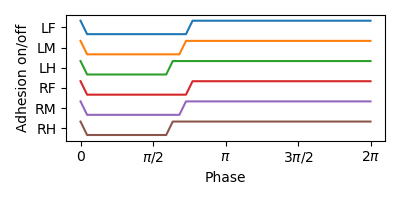

In [22]:
onoff_signal = np.zeros((6, phase_grid.size), dtype=bool)
for i in range(phase_grid.size):
    onoff_signal[:, i] = get_adhesion_onoff(phase_grid[i])

fig, ax = plt.subplots(figsize=(4, 2), tight_layout=True)
for i in range(6):
    ax.plot(phase_grid, onoff_signal[i, :] - i * 1.5)
ax.set_yticks(-np.arange(6) * 1.5 + 0.5)
ax.set_yticklabels(legs)
ax.set_xticks(np.arange(5) * np.pi / 2)
ax.set_xticklabels(["0", r"$\pi/2$", r"$\pi$", r"3$\pi$/2", r"$2\pi$"])
ax.set_xlabel("Phase")
ax.set_ylabel("Adhesion on/off")
fig.savefig(output_dir / "adhesion_signal.png")

We can rerun the NeuroMechFly simulation with adhesion enabled. The parts of the code that have been changed are indicated with comments.

In [23]:
run_time = 1

fly = Fly(
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=True,
)
cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
)
sim = SingleFlySimulation(fly=fly, cameras=[cam], timestep=1e-4)
cpg_network.reset()

ang = []

obs, info = sim.reset()
for _ in trange(int(run_time / sim.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    adhesion_onoff = get_adhesion_onoff(cpg_network.curr_phases)
    ang.append([joints_angles[dof] for dof in fly.actuated_joints])
    action = {
        "joints": np.array([joints_angles[dof] for dof in fly.actuated_joints]),
        ##### THIS LINE IS NEW #####
        "adhesion": adhesion_onoff.astype(int),
        ############################
    }
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "cpg_controller_with_adhesion.mp4", 0)
Video(output_dir / "cpg_controller_with_adhesion.mp4")

100%|██████████| 10000/10000 [00:43<00:00, 229.37it/s]


In summary, in this tutorial we have (1) implemented a Python class for CPG networks, (2) used it to modulate the stepping of legs using experimentally recorded data, (3) plugged this controller into the NeuroMechFly embodiment, and (4) added leg adhesion to the simulation. Note that the controller we built here is feedforward — that is, mechanosensory feedback is not used by the controller (except the position feedback in the PD controller for individual joints). In the next tutorial, we will build a rule-based controller where leg coordination is accomplished using sensory feedback in a more distributed manner.

# Exercise 1: CPG parameters
This exercise requires `ipympl` to be installed for interactive plotting. You can install it using `conda` by running the following commands in your terminal (recommended):
```bash
conda activate flygym
conda install -c conda-forge ipympl
```
If you do not have `conda` installed, you may use `pip` to install `ipympl` by uncommenting the cell below and running it.

In [24]:
# !pip install ipympl

Reopen the notebook after installing `ipympl`.

If the interactive plot does not work in VS Code, try using the browser-based Jupyter interface.
```bash
conda activate flygym
jupyter notebook
```


In this section, we will visualize the activity of the CPG controller with 3 oscillators using an interactive plot. Change the parameters of the CPG network and reflect on how they affect the network behavior.

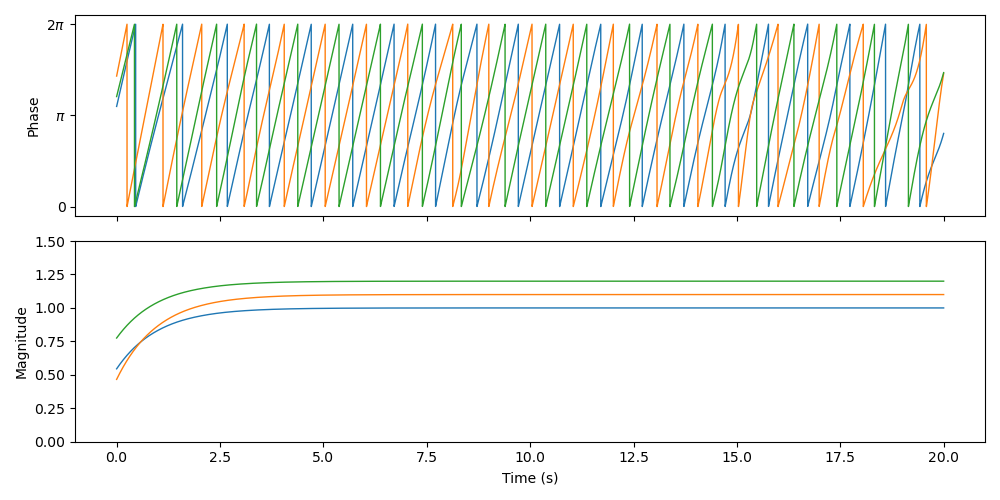

In [25]:
%matplotlib widget
from interactive_plot import interactive_plot

interactive_plot()

# Exercise 2: Hexapod gaits
In this section, we will simulate three gaits (tripod, tetrapod, wave) that has been described in hexapods. For detailed descriptions of the gaits, refer to [DeAngelis et al, 2019](https://elifesciences.org/articles/46409#s2-3).

![](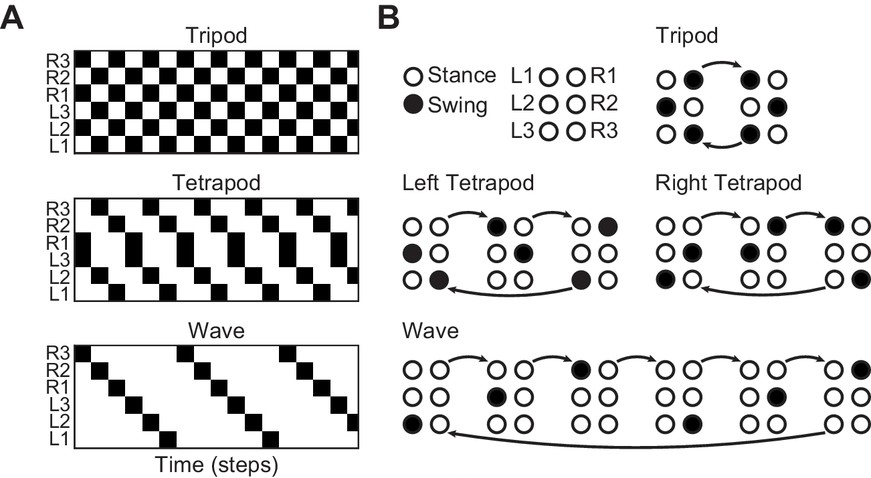
)
</div>

(Adapted from [DeAngelis et al, 2019](https://doi.org/10.7554/eLife.46409))

Fill in the phase bias matrices below:

In [52]:
tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)

tetrapod_phase_biases = (
    2 * np.pi # note that the values below are pre-multiplied by 2*pi
    * np.array(
        [
            # ================================================
            # TODO: fill in the phase biases for tetrapod gait
            [0, 1, 2, 0, 1, 2],
            [2, 0, 1, 2, 0, 1],
            [1, 2, 0, 1, 2, 0],
            [1, 2, 0, 1, 2, 0],
            [0, 1, 2, 0, 1, 2],
            [2, 0, 1, 2, 0, 1],
            # ================================================
        ]
    )
    / 3
)

wave_phase_biases = (
    2 * np.pi # note that the values below are pre-multiplied by 2*pi
    * np.array(
        [
            # ================================================
            # TODO: fill in the phase biases for wave gait
            [0, 1, 2, 3, 4, 5],
            [5, 0, 1, 2, 3, 4],
            [4, 5, 0, 1, 2, 3],
            [3, 4, 5, 0, 1, 2],
            [2, 3, 4, 5, 0, 1],
            [1, 2, 3, 4, 5, 0],
            # ================================================
        ]
    )
    / 6
)

gait_phase_biases = {
    "tripod": tripod_phase_biases,
    "tetrapod": tetrapod_phase_biases,
    "wave": wave_phase_biases,
}

In [53]:
def plot_gait_diagram(sim, leg_ap_positions, title):
    """Function to detect and plot the swing-stance patterns from
    the postions of the legs along the anterior-posterior axis
    """
    from matplotlib.patches import Patch
    from scipy.ndimage import gaussian_filter1d
    from scipy.signal import find_peaks

    leg_labels = ["LF", "LM", "LH", "RF", "RM", "RH"]
    fig, axs = plt.subplots(
        6, 1, figsize=(7, 2), sharex=True, gridspec_kw={"hspace": 0}
    )
    for i, (ax, y) in enumerate(zip(axs, leg_ap_positions.T)):
        vel = gaussian_filter1d(y, sigma=50, order=1)
        # locate frames at which the leg move forward at a high speed
        _, prop = find_peaks(vel, distance=600, width=100)
        intervals = np.column_stack([prop["left_ips"], prop["right_ips"]])
        for interval in intervals * sim.timestep:
            patch = ax.axvspan(*interval, color="k", lw=0, label="Swing")
        lines = ax.plot(t, y, color="r", label="Leg position (higher = more anterior)")
        ax.set_ylabel(leg_labels[i], rotation=0, ha="right", va="center")
        ax.set_xlim(0, 1)
        ax.set_yticks([])

    handles = [Patch(fc="w", ec="k", label="Stance"), patch, lines[0]]
    axs[0].legend(
        handles=handles,
        loc="lower center",
        bbox_to_anchor=(0.5, 1),
        ncols=3,
        frameon=False,
    )
    axs[-1].set_xlabel("Time (s)")
    fig.suptitle(f"{title.capitalize()} gait", y=1.15)

In [54]:
for gait, phase_biases in gait_phase_biases.items():
    run_time = 1

    cpg_network = CPGNetwork(
        timestep=1e-4,
        intrinsic_freqs=intrinsic_freqs,
        intrinsic_amps=intrinsic_amps,
        coupling_weights=coupling_weights,
        phase_biases=phase_biases,
        convergence_coefs=convergence_coefs,
    )

    fly = Fly(
        init_pose="stretch",
        actuated_joints=all_leg_dofs,
        control="position",
        enable_adhesion=True,
        draw_adhesion=True,
    )
    cam = ZStabilizedCamera(
        attachment_point=fly.model.worldbody,
        camera_name="camera_top",
        targeted_fly_names=[fly.name],
        play_speed=0.1,
    )
    sim = SingleFlySimulation(fly=fly, cameras=[cam], timestep=1e-4)
    cpg_network.reset()

    n_steps = int(run_time / sim.timestep)
    legs_ap_pos = np.zeros((n_steps, 6))

    obs, info = sim.reset()
    for j in trange(int(run_time / sim.timestep)):
        cpg_network.step()
        joints_angles = {}
        for i, leg in enumerate(legs):
            psi = psi_funcs[leg](cpg_network.curr_phases[i])
            psi_base = psi_funcs[leg](psi_rest_phases[i])
            adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
            for dof, angle in zip(dofs_per_leg, adjusted_psi):
                joints_angles[f"joint_{leg}{dof}"] = angle
        adhesion_onoff = get_adhesion_onoff(cpg_network.curr_phases)
        ang.append([joints_angles[dof] for dof in fly.actuated_joints])
        action = {
            "joints": np.array([joints_angles[dof] for dof in fly.actuated_joints]),
            "adhesion": adhesion_onoff.astype(int),
        }
        obs, reward, terminated, truncated, info = sim.step(action)
        sim.render()

        # project the tips of the legs onto the anterior-posterior axis of the fly
        legs_ap_pos[j] = (obs["end_effectors"] - obs["fly"][0]) @ obs["fly_orientation"]

    cam.save_video(output_dir / f"{gait}.mp4", 0)

    plot_gait_diagram(sim, legs_ap_pos, gait)
    plt.savefig(output_dir / f"{gait}.png", bbox_inches="tight")
    plt.close()

100%|██████████| 10000/10000 [00:31<00:00, 320.71it/s]


In [55]:
import ipywidgets

ipywidgets.VBox(
    [
        ipywidgets.HBox(
            [
                ipywidgets.Video.from_file(output_dir / f"{gait}.mp4", width=240),
                ipywidgets.Image.from_file(output_dir / f"{gait}.png", height=240),
            ]
        )
        for gait in ["tripod", "tetrapod", "wave"]
    ]
)

# Exercise 3: Terrains
In this section, we will look at the performance of the CPG controller on a rugged terrain.

In [42]:
################################################################################
# TODO: import the GappedTerrain class from the flygym.arena module and create
# an instance of it
from flygym.arena import GappedTerrain

# from flygym.arena import ...
arena = GappedTerrain(
    gap_width=0.1
)

################################################################################

intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 1000

cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=1,
)

run_time = 1

fly = Fly(
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=True,
)
cam = ZStabilizedCamera(
    attachment_point=fly.model.worldbody,
    camera_name="camera_left",
    targeted_fly_names=[fly.name],
    play_speed=0.1,
)
sim = SingleFlySimulation(fly=fly, cameras=[cam], arena=arena, timestep=1e-4)
cpg_network.reset()

obs, info = sim.reset()
for _ in trange(int(run_time / sim.timestep)):
    cpg_network.step()
    joints_angles = {}
    for i, leg in enumerate(legs):
        psi = psi_funcs[leg](cpg_network.curr_phases[i])
        psi_base = psi_funcs[leg](psi_rest_phases[i])
        adjusted_psi = psi_base + (psi - psi_base) * cpg_network.curr_magnitudes[i]
        for dof, angle in zip(dofs_per_leg, adjusted_psi):
            joints_angles[f"joint_{leg}{dof}"] = angle
    adhesion_onoff = get_adhesion_onoff(cpg_network.curr_phases)
    action = {
        "joints": np.array([joints_angles[dof] for dof in fly.actuated_joints]),
        "adhesion": adhesion_onoff.astype(int),
    }
    obs, reward, terminated, truncated, info = sim.step(action)
    sim.render()

cam.save_video(output_dir / "cpg_controller_on_gapped_terrain.mp4", 0)
Video(output_dir / "cpg_controller_on_gapped_terrain.mp4")

100%|██████████| 10000/10000 [02:10<00:00, 76.56it/s]


Does the CPG controller work well on the gapped terrain? If not, how can it be improved?

TODO: Add your answer here